# Objective

* go through processing routine
* Do we have the relvant calibration files
    * What instruments are involved?
    * 1625 filterfunction for relevant instruments?

# Strategy

Apply Lab calibration
* ~~There seems to be an error in the caluculation of the direct horizontal and normal in those products for splash (not shown in the publicated data).~~
* This part should actually be somewhat hard coded in a script somewhere in SURFRAD package!
* Set it up so it prcesses all new data that is comming in
* imitate what has been done in /home/grad/htelg/projects/ASR/splash/apply_calibrations/calibrate_v0.2.ipynb
* We will need MFRSR only
* use most recent Charls calibrations

Based on the files created above come up with a code to get AOD based on Lab cals
* choose single number for top fo the atmosphere spectral irradiance
* how is the earth-sun distance implemented now, deviation from mean?


# Calibrate files

In [3]:
import atmPy.data_archives.NOAA_ESRL_GMD_GRAD.surfrad.surfrad as atmsrf

# Make AOD

In [4]:
import atmPy.radiation.retrievals.spectral_irradiance as atmspec

In [5]:
fn = '/nfs/grad/campaigns/splash/data_products/spectral_irradiances_downwelling/cbc/cal.2021/v0.2/cbc_specflux_20230528.nc'
dssf = xr.open_dataset(fn)
fn = '/nfs/grad/campaigns/splash/data_products/spectral_surface_albedo/v1.0/cbc/cbc.spectral_surface_albedo.20230528.nc'
dsal = xr.open_dataset(fn)

In [6]:
atmspec.CombinedGlobalDiffuseDirect

atmPy.radiation.retrievals.spectral_irradiance.CombinedGlobalDiffuseDirect

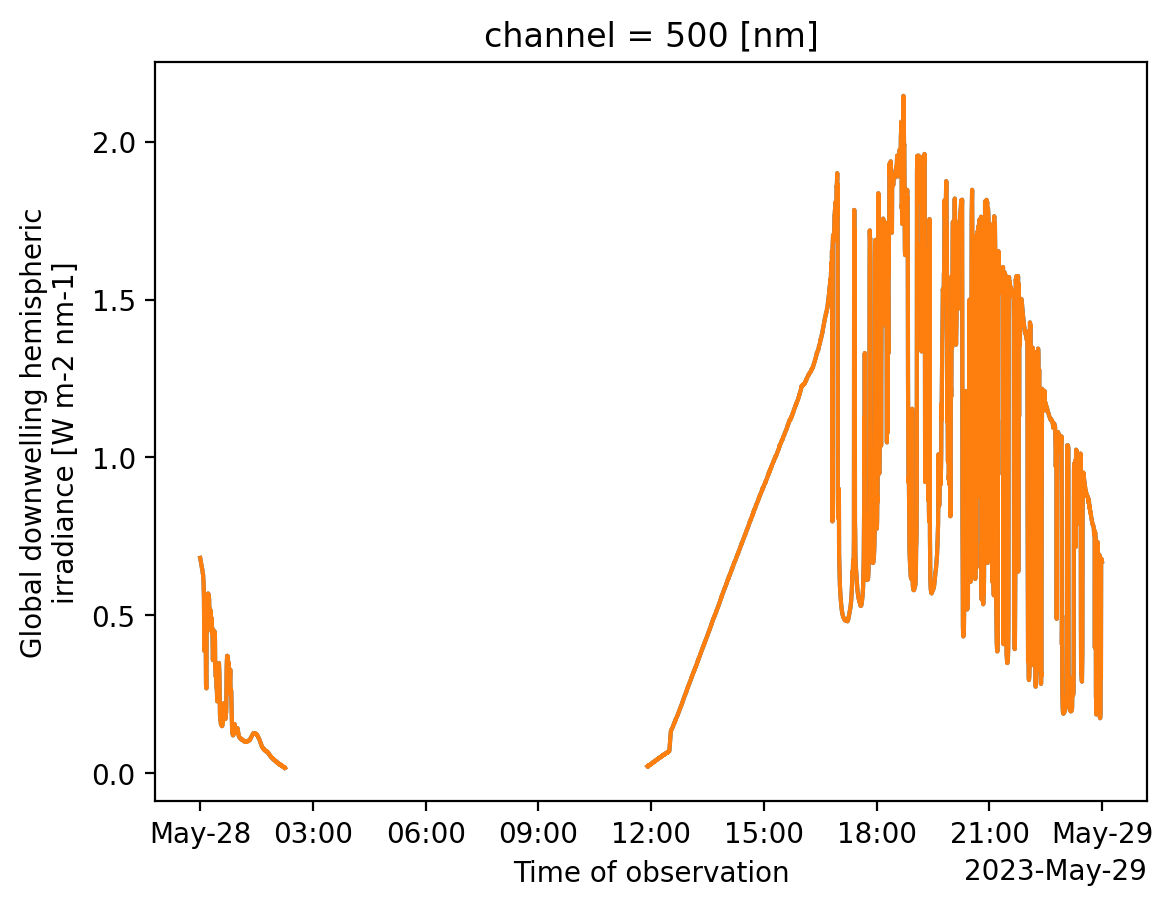

In [7]:
dssf.global_horizontal.sel(channel=550, method='nearest').plot()
dsal.downwelling_hemispheric_irradiance.sel(channel=550, method='nearest').plot()

## Use the top of the atmosphere solar constant

Once you correct for the variation in the Earth–Sun distance (which causes the ~±3.5% annual cycle in irradiance), the solar irradiance at the top of the atmosphere (the “solar constant”) is essentially constant:  

- **Mean value**: ~1361 W m⁻² (according to TIM/SORCE and other modern radiometers).  
- **Short-term variability**:  
  - On the timescale of minutes to hours: very small (≲0.01%), except during solar flares.  
  - Over the 11-year solar cycle: about ±0.05% to ±0.1% (~1–1.5 W m⁻²).  
- **Longer term trends**: No statistically significant secular trend has been measured over the past 40+ years of satellite monitoring; variations remain within ~1 W m⁻².  

👉 So, once Earth–Sun distance is accounted for, **the top-of-atmosphere solar irradiance is stable to better than 0.1%**, with only the solar cycle and transient events (like flares) causing small changes.  

Do you want me to also show how this translates into changes in absorbed solar energy by Earth (W m⁻² at the surface averaged globally)?


In [15]:
import atmPy.data_archives.NOAA_ESRL_GMD_GRAD.surfrad.surfrad as atmsrf
import atmPy.radiation.retrievals.spectral_irradiance as atmspec

In [ ]:

fn = '/nfs/grad/campaigns/splash/data_products/spectral_irradiances_downwelling/cbc/cal.2021/v0.2/cbc_specflux_20220625.nc'
# fn = '/nfs/grad/campaigns/splash/data_products/spectral_irradiances_downwelling/cbc/cal.sbs2021/v0.2/cbc_specflux_20230528.nc'
dssf = xr.open_dataset(fn)
dssf = dssf.rename({'channel_wavelength': 'channel_center'})
ro = atmspec.CombinedGlobalDiffuseDirect(dssf)

In [247]:
reload(atmspec)
reload(atmsrf)

<module 'atmPy.data_archives.NOAA_ESRL_GMD_GRAD.surfrad.surfrad' from '/home/grad/htelg/prog_dev/atm-py/atmPy/data_archives/NOAA_ESRL_GMD_GRAD/surfrad/surfrad.py'>

In [248]:
fld = pl.Path('/nfs/grad/campaigns/splash/data_products/spectral_irradiances_downwelling/cbc/cal.2021/v0.2/')
fns = list(fld.glob('*'))
fns.sort()

(<Figure size 1280x960 with 1 Axes>,
 <Axes: title={'center': 'channel = 500'}, xlabel='datetime', ylabel='direct_normal'>)

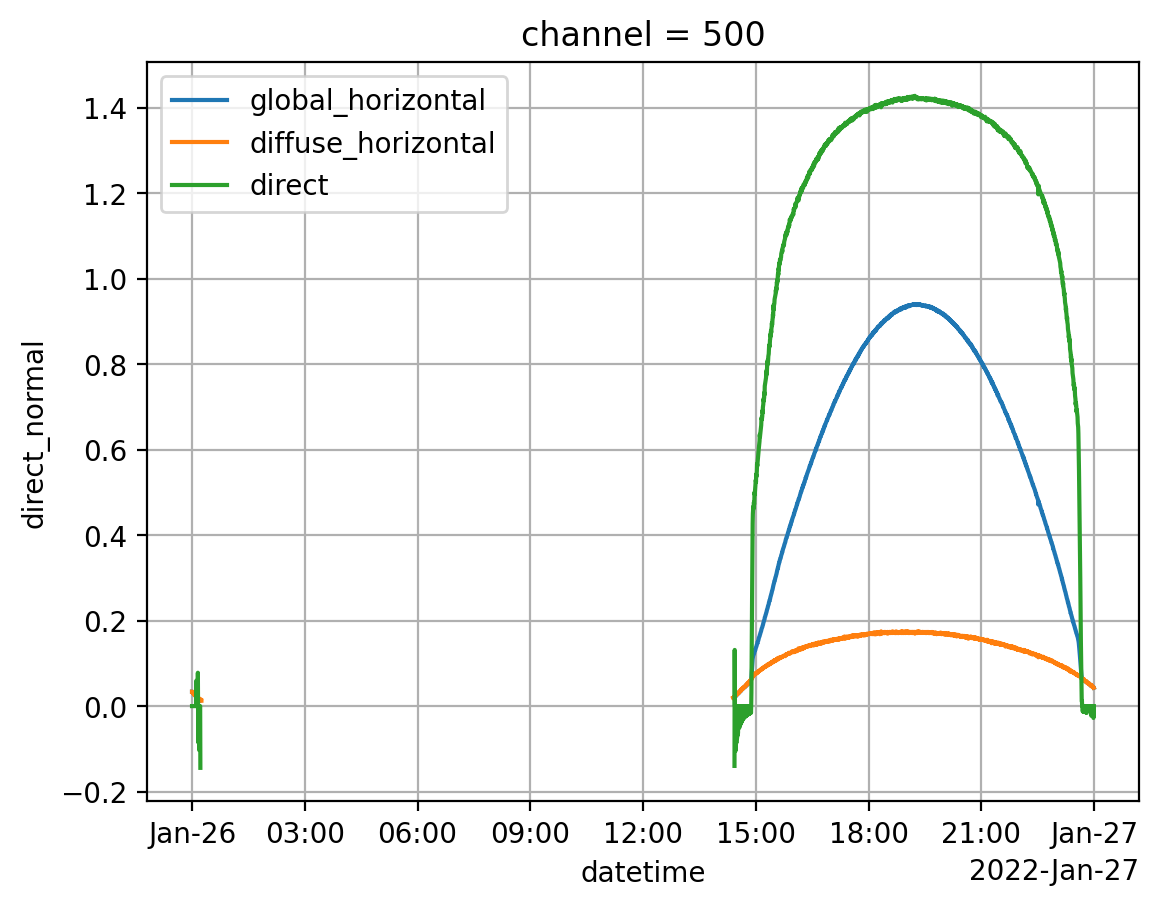

In [249]:
i = 102 # 102: claer sky
# i += 1
fn = fns[i]
dssf = xr.open_dataset(fn)
# dssf = dssf.rename({'channel_wavelength': 'channel_center'})
ro = atmspec.CombinedGlobalDiffuseDirect(dssf)
ro.plot_overview(show_alltime=False)

In [250]:
i

102

In [251]:
ro.direct_normal_irradiation.settings_calibration = 'toa_radiation'

/home/grad/htelg/prog_dev/atm-py/atmPy/radiation/solar.py:125: UserWarning: Discarding nonzero nanoseconds in conversion.
  date = date.to_pydatetime()


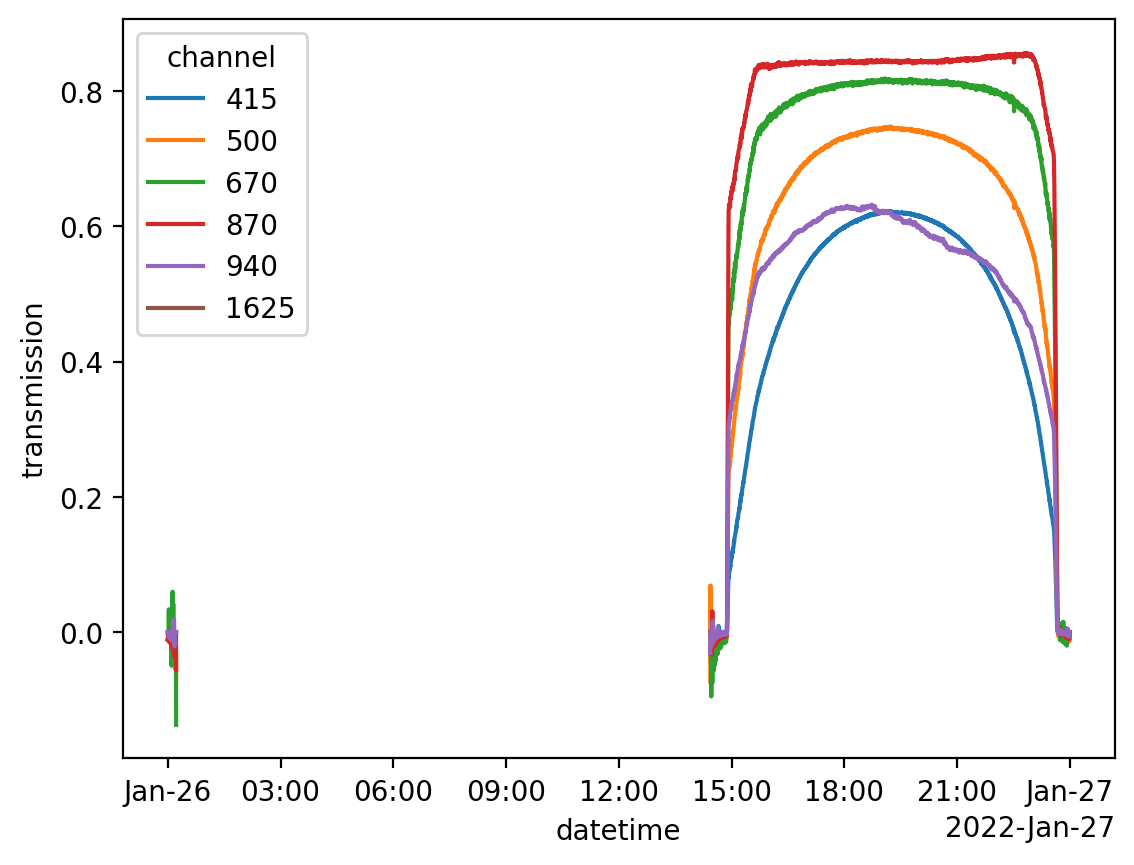

In [252]:
ro.direct_normal_irradiation.transmission.plot.line(x = 'datetime')

/export2/htelg/programs/miniconda3/envs/py12t2/lib/python3.12/site-packages/xarray/computation/apply_ufunc.py:818: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/export2/htelg/programs/miniconda3/envs/py12t2/lib/python3.12/site-packages/xarray/computation/apply_ufunc.py:818: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


(0.0, 1.0)

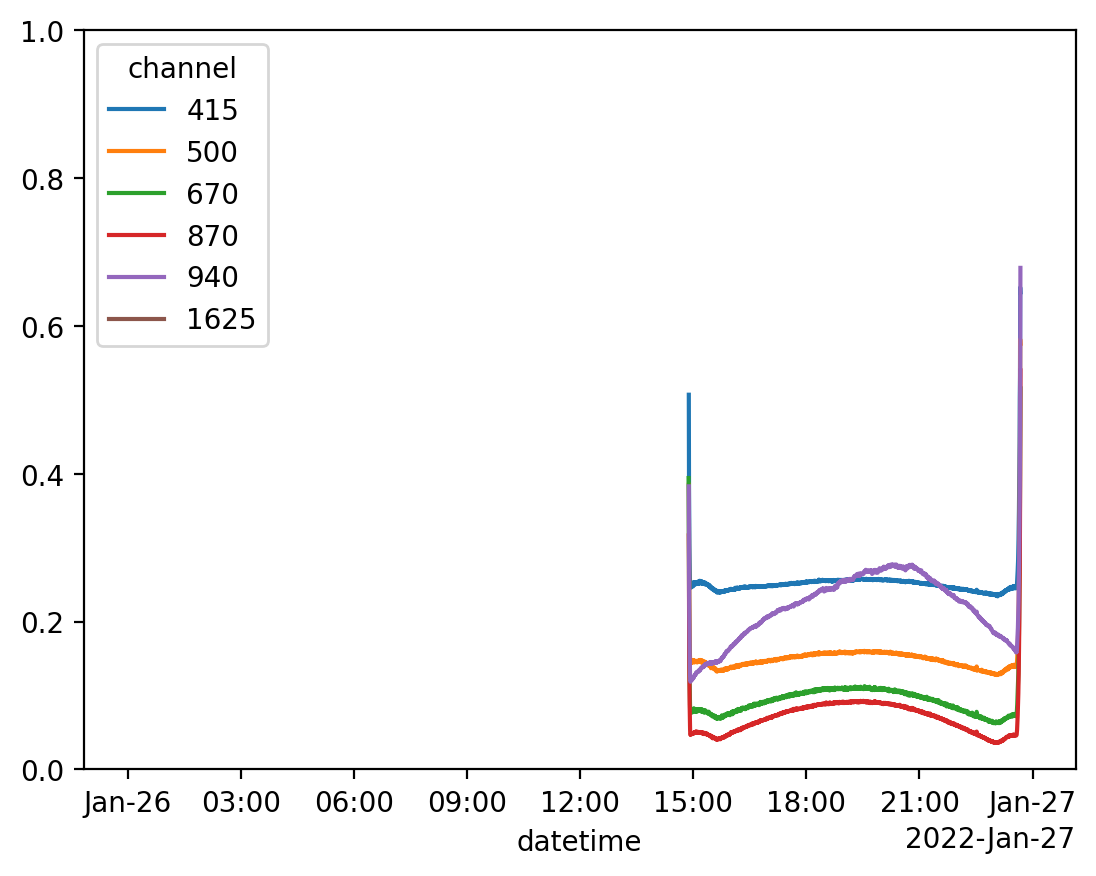

In [253]:
f,a = plt.subplots()
ro.direct_normal_irradiation.od_total.plot.line(x='datetime', ax=a)
a.set_ylim(0,1)

In [254]:
ro.direct_normal_irradiation.od_rayleigh

FileNotFoundError: Could not find met data. Make sure the "settings_metdata" attribute is set correctly! The following error was raised: [Errno 2] No such file or directory: '/nfs/grad/surfrad/products_level1/radiation_netcdf/TMP/srf_rad_full_TMP_20220126.nc'

# read met data1

* read the correct year from joes folder
* do a resample or reindex?

In [ ]:
def read_splash_met_data(site):    
    year = pd.to_datetime(ro.dataset.datetime.values[0]).year
    p2f_met = f'/home/grad/sedlar/data/splash/surfrad/all_variables/{site}_concat_surfrad_all_variables{year}.nc'
    dsmet = xr.open_dataset(p2f_met)
    dsmet['time'] = pd.to_datetime(dsmet['time'], unit='d')
    pt_interp = dsmet[['temp','pressure']].interp(time = ro.dataset.datetime)
    return pt_interp


In [ ]:
ro.direct_normal_irradiation.settings_metdata = lambda x: read_splash_met_data('cbc')

function

In [293]:
dssf

<xarray.Dataset> Size: 1MB
Dimensions:                   (datetime: 4301, channel: 6)
Coordinates:
  * datetime                  (datetime) datetime64[ns] 34kB 2022-01-26 ... 2...
  * channel                   (channel) int64 48B 415 500 670 870 940 1625
Data variables:
    alltime                   (datetime, channel) int64 206kB ...
    global_horizontal         (datetime, channel) float64 206kB ...
    diffuse_horizontal        (datetime, channel) float64 206kB ...
    channel_wavelength        (channel) float64 48B ...
    direct_horizontal         (datetime, channel) float64 206kB ...
    cosine_calibraion_direct  (datetime, channel) float64 206kB ...
    solar_zenith_angle        (datetime) float64 34kB ...
    solar_azimuth_angle       (datetime) float64 34kB ...
    direct_normal             (datetime, channel) float64 206kB ...
Attributes: (12/17)
    site_longitude:         -106.918945
    site_latitude:          38.853149
    site_elevation:         0
    site:                   TMP
    site_name:              unknown
    calibrated_irradiance:  False
    ...                     ...
    instrument_type:        mfrsr
    day_complete:           True
    parent_files:           /nfs/grad/Inst/MFR/Campaign/cbc/mfrsr/raw/2022/cb...
    product_version:        0.1
    calibrated_spectral:    True
    clalibration_cosine:    True

# Apply cloud screening

In [ ]:
atmsrf.open_path('/nfs/grad/Inst/')